In [ ]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt

In [ ]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
    
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])
lc_classes

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)

In [ ]:
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

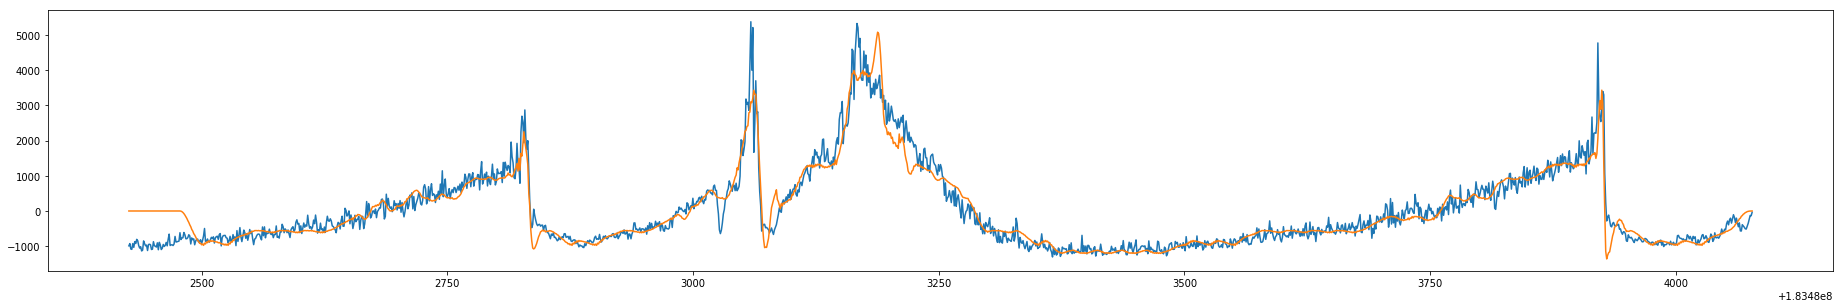

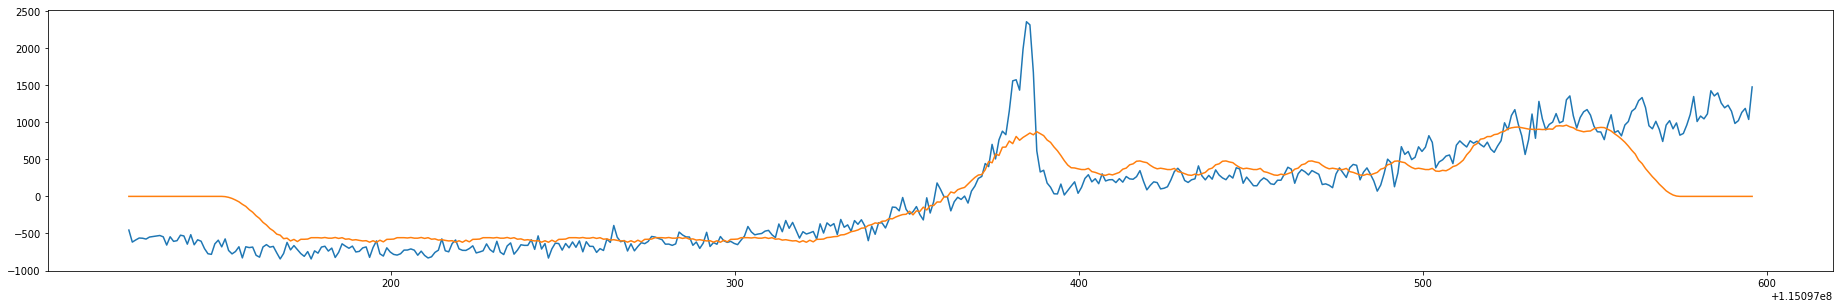

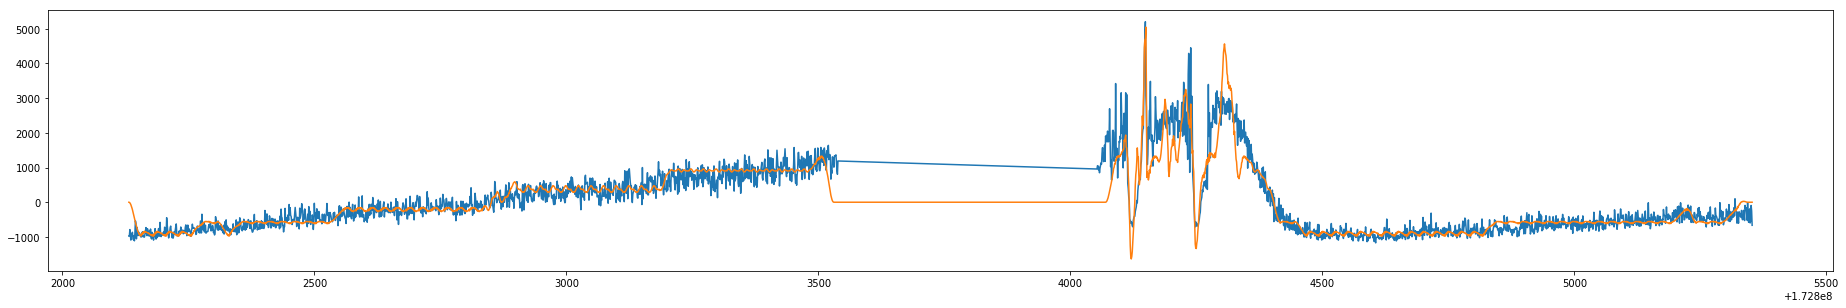

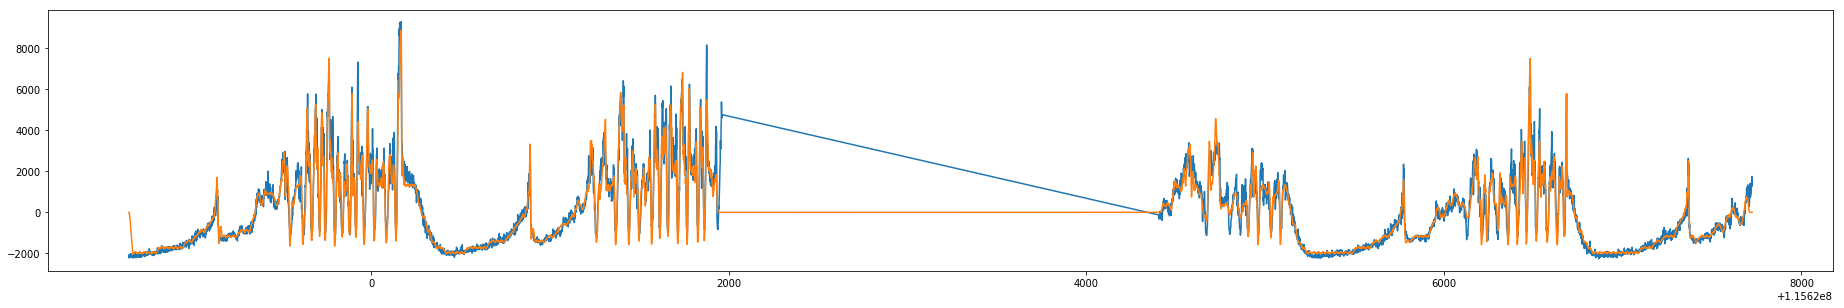

In [317]:
from sklearn.cluster import KMeans
import segment_cluster as sc
import importlib
importlib.reload(sc)
cluster=KMeans(n_clusters=100)
time_stamps=False
offset=True

#lets try a theta doped set of beta time curves
beta_ys=np.where(np.array(y_train)=='beta')[0]
all_train_segments=[]
for ts_i in beta_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, 50, 2, time_stamps=time_stamps)
    c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(c_train_segments)
cluster.fit(np.array(c_train_segments))

#use the validation set to measure the reconstruction error difference between the same class observations and outliers
beta_ys=np.where(np.array(y_valid)=='beta')[0]
time_stamps=True
offset=False
reco_error=[]
seg_slide=25
for ts_id in beta_ys:
    test_ts=x_valid[ts_id]
    test_segments= sc.segmentation(test_ts, 50, seg_slide, time_stamps=time_stamps)
    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
    reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)
    error=np.sqrt(((test_ts[1][seg_slide:-seg_slide]-reco[1][seg_slide:-seg_slide])**2).sum())
    reco_error.append((ts_id, error))
    plt.figure(figsize=(6.4*5, 4.8))
    plt.plot(test_ts[0],test_ts[1])
    plt.plot(reco[0],reco[1])
    plt.show()

In [ ]:
for seg in c_test_segments:
    plt.plot(seg[0],seg[1])
plt.show()

In [320]:
from sklearn.cluster import KMeans
import segment_cluster as sc
import importlib
importlib.reload(sc)

cluster=KMeans(n_clusters=100)
# training and test time series, both time[0] and count rate[1]
train_ts=x_train[5]
test_ts=x_train[5]

offset=True
time_stamps=True

#train the model
train_segments=sc.segmentation(train_ts, 50, 2, time_stamps=time_stamps)
c_train_segments=sc.center_offset(train_segments, train_ts, offset=offset, time_stamps=time_stamps)
cluster.fit(np.array(c_train_segments)[:,1])

#test segments
test_segments= sc.segmentation(test_ts, 50, 25, time_stamps=time_stamps)
c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)

#reconstruct the test time series
reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)

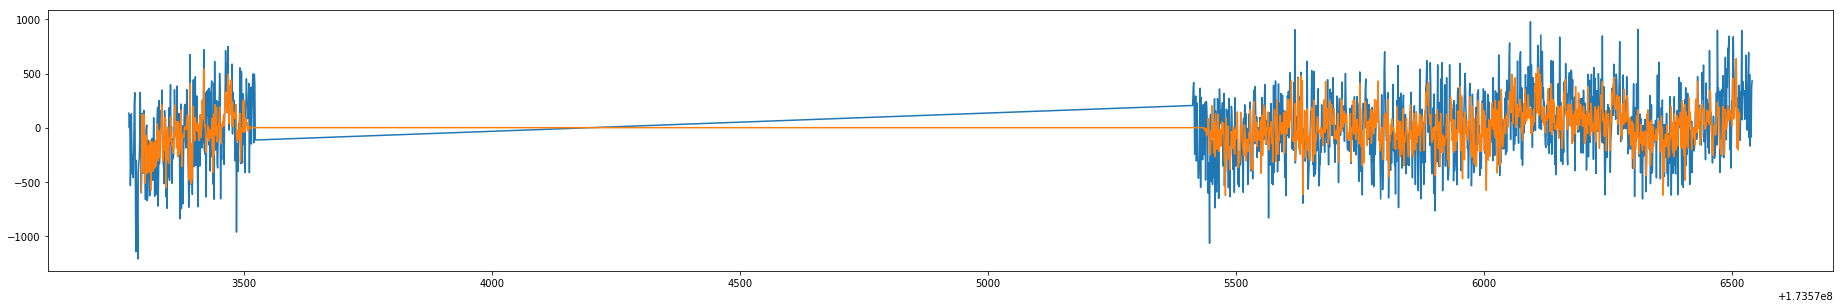

In [321]:
plt.figure(figsize=(6.4*5, 4.8))
plt.plot(test_ts[0],test_ts[1])
plt.plot(reco[0][25:-25],reco[1][25:-25])
#plt.plot(reco[0][25:-25], reco[1][25:-25]-test_ts[1][25:-25])
plt.show()

In [ ]:
np.sqrt(((test_ts[1][25:-25]-reco[1][25:-25])**2).sum())